<a href="https://colab.research.google.com/github/OhJin-Soo/ktb_ai/blob/main/jayvi(%EC%98%A4%EC%A7%84%EC%88%98)_ktb_8%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_1%2C2(Transformer_%EA%B5%AC%ED%98%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Epoch 1/40] train_loss=1.0606 train_acc=0.4274 | val_loss=0.9308 val_acc=0.7037
[Epoch 5/40] train_loss=0.6269 train_acc=0.6694 | val_loss=0.5568 val_acc=0.7037
[Epoch 10/40] train_loss=0.3775 train_acc=0.9194 | val_loss=0.2875 val_acc=0.9630
[Epoch 15/40] train_loss=0.2008 train_acc=0.9355 | val_loss=0.2548 val_acc=0.8889
[Epoch 20/40] train_loss=0.1555 train_acc=0.9597 | val_loss=0.2094 val_acc=0.9259
[Epoch 25/40] train_loss=0.0867 train_acc=0.9839 | val_loss=0.1943 val_acc=0.9630
[Epoch 30/40] train_loss=0.0786 train_acc=0.9758 | val_loss=0.2000 val_acc=0.9630
[Epoch 35/40] train_loss=0.0190 train_acc=1.0000 | val_loss=0.2445 val_acc=0.9259
[Epoch 40/40] train_loss=0.0333 train_acc=0.9919 | val_loss=0.3306 val_acc=0.9259

=== Test results ===
loss=0.1098, acc=0.9630

Classification report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         9
           1     0.9167    1.0000    0.9565        11
           2     1.0000    0.85

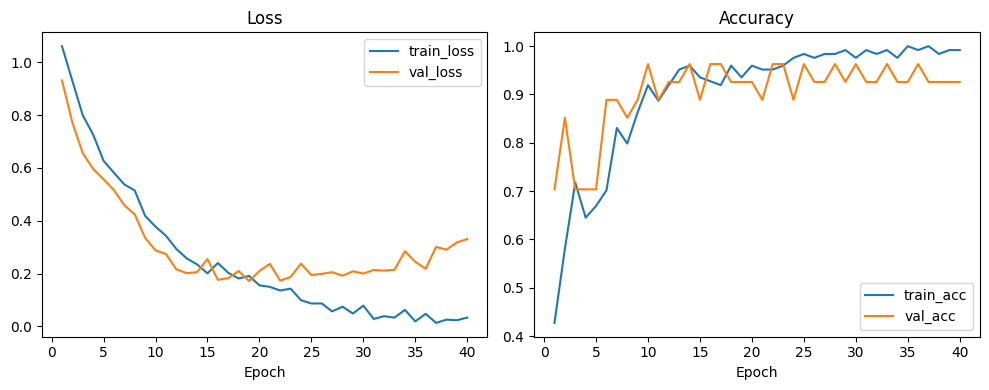

Saved checkpoint -> saved_models/transformer_wine.pth

Sample predictions (first 8 test rows):
true=1  pred=1
true=1  pred=1
true=0  pred=0
true=1  pred=1
true=2  pred=2
true=1  pred=1
true=0  pred=0
true=1  pred=1


In [1]:
# train_transformer_wine.py
"""
Clean Transformer Encoder classifier (PyTorch) trained on sklearn's Wine dataset.
- Each numeric feature is treated as a token in a sequence (seq_len = n_features).
- Clean code: PositionalEncoding, small TransformerEncoder, mean pooling -> classifier.
- Saves model checkpoint with scaler and metadata.
"""

import os
import math
import random
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -------------------------
# Reproducibility / device
# -------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Dataset: Wine (real)
# -------------------------
data = load_wine(as_frame=True)
X = data.data.values     # shape (n_samples, n_features)
y = data.target.values
feature_names = list(data.feature_names)
n_features = X.shape[1]
n_classes = len(np.unique(y))

# split: train 70% / val 15% / test 15%
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=seed, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.17647, random_state=seed, stratify=y_trainval)

# scale features (important)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# -------------------------
# PyTorch Dataset
# -------------------------
class TabularSequenceDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # Return (seq_len = n_features) vector and label
        return self.X[idx], self.y[idx]

train_ds = TabularSequenceDataset(X_train, y_train)
val_ds = TabularSequenceDataset(X_val, y_val)
test_ds = TabularSequenceDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# -------------------------
# Model components
# -------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

class SimpleTransformerClassifier(nn.Module):
    def __init__(self, n_features, d_model=64, n_heads=4, num_layers=3, dim_feedforward=128, dropout=0.1, n_classes=3):
        super().__init__()
        self.d_model = d_model
        # Project scalar feature -> embedding
        self.feature_proj = nn.Linear(1, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=n_features)
        # Use batch_first=True for easier shapes
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads,
                                                   dim_feedforward=dim_feedforward, dropout=dropout,
                                                   activation='relu', batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, n_classes)
        )

    def forward(self, x):
        # x: (batch, seq_len) where seq_len = n_features
        batch_size, seq_len = x.shape
        # project each scalar into vector
        x = x.view(batch_size * seq_len, 1)           # (batch*seq_len, 1)
        x = self.feature_proj(x)                      # (batch*seq_len, d_model)
        x = x.view(batch_size, seq_len, self.d_model) # (batch, seq_len, d_model)
        x = self.pos_enc(x)
        x = self.transformer_encoder(x)               # (batch, seq_len, d_model)
        x = x.mean(dim=1)                             # mean pool across tokens
        logits = self.classifier(x)                   # (batch, n_classes)
        return logits

# -------------------------
# Train / Eval
# -------------------------
model = SimpleTransformerClassifier(n_features=n_features, d_model=64, n_heads=4, num_layers=3,
                                    dim_feedforward=128, dropout=0.1, n_classes=n_classes).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

def evaluate(model, loader):
    model.eval()
    ys, ys_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1).cpu().numpy()
            ys_pred.extend(preds.tolist())
            ys.extend(yb.cpu().numpy().tolist())
    return total_loss / len(loader.dataset), accuracy_score(ys, ys_pred), np.array(ys), np.array(ys_pred)

n_epochs = 40
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    all_preds = []; all_trues = []
    for xb, yb in train_loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        all_preds.extend(logits.argmax(dim=1).cpu().numpy().tolist())
        all_trues.extend(yb.cpu().numpy().tolist())
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_trues, all_preds)
    val_loss, val_acc, _, _ = evaluate(model, val_loader)
    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accs.append(train_acc); val_accs.append(val_acc)
    if epoch==1 or epoch%5==0:
        print(f"[Epoch {epoch}/{n_epochs}] train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

# final test
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader)
print("\n=== Test results ===")
print(f"loss={test_loss:.4f}, acc={test_acc:.4f}")
print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# plot curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), train_losses, label='train_loss')
plt.plot(range(1, n_epochs+1), val_losses, label='val_loss')
plt.title("Loss"); plt.xlabel("Epoch"); plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), train_accs, label='train_acc')
plt.plot(range(1, n_epochs+1), val_accs, label='val_acc')
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.legend()
plt.tight_layout()
plt.show()

# save model + scaler
os.makedirs("saved_models", exist_ok=True)
save_path = "saved_models/transformer_wine.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'feature_names': feature_names,
    'n_features': n_features,
    'n_classes': n_classes
}, save_path)
print(f"Saved checkpoint -> {save_path}")

# sample inference (first 8 samples from test)
print("\nSample predictions (first 8 test rows):")
for i in range(min(8, len(y_true))):
    print(f"true={y_true[i]}  pred={y_pred[i]}")